In [48]:
import pandas as pd
import numpy as np
import shutil
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

In [49]:
df = pd.read_json("datasets/PlotQA/src/test/annotations.json")
df.head()

,models,type,general_figure_info,image_index
0,"[{'name': 'Goods and services', 'color': '#F0E...",dot_line,{'title': {'text': 'Payments made towards prim...,0
1,"[{'name': 'Arms exports', 'color': '#FFFF00', ...",dot_line,{'title': {'text': 'Arm exports and imports in...,1
2,"[{'name': 'Infant', 'color': '#191970', 'label...",dot_line,{'title': {'text': 'Mortality rates in Marshal...,2
3,"[{'name': 'Female', 'color': '#D2B48C', 'label...",dot_line,{'title': {'text': 'Percentage of repeaters in...,3
4,"[{'name': 'US$', 'color': '#B8860B', 'label': ...",dot_line,{'title': {'text': 'Total resource balance of ...,4


In [50]:
df["general_figure_info"][10052]["x_axis"]["major_labels"]["values"]

['0', '20', '40', '60', '80', '100', '0', '20', '40', '60', '80', '100']

**There are 6070 single plots, 6283 double plots... and so on**

In [51]:
df["models"].apply(len).value_counts()

models
3    11601
4     9703
2     6283
1     6070
Name: count, dtype: int64

In [52]:
df["models"][14975]

[{'name': 'Trademark applications',
  'labels': 'Trademark applications',
  'width': 0.15,
  'colors': '#8B008B',
  'bboxes': [{'y': 552, 'x': 178, 'w': 4, 'h': 18},
   {'y': 429, 'x': 178, 'w': 5, 'h': 18},
   {'y': 306, 'x': 178, 'w': 255, 'h': 18},
   {'y': 183, 'x': 178, 'w': 314, 'h': 18},
   {'y': 60, 'x': 178, 'w': 826, 'h': 18}],
  'y': ['Caribbean small states',
   'Central Europe',
   'Euro area',
   'European Union',
   'High income'],
  'x': [2189, 2634, 145871, 180019, 473421]}]

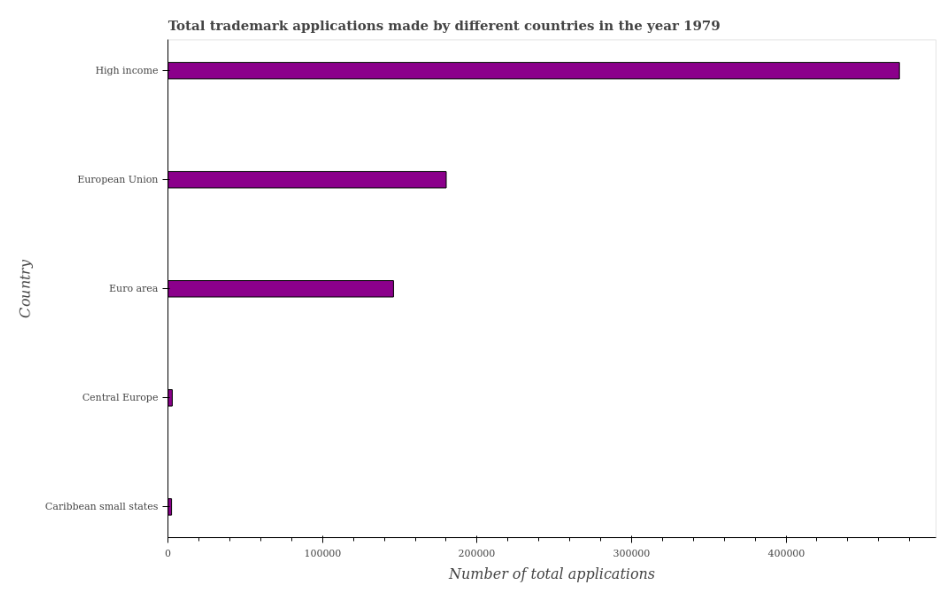

In [53]:
image = Image.open("datasets/PlotQA/src/test/png/14975.png")

plt.figure(figsize=(12,12))
plt.axis("off")  # Hide axes
plt.imshow(image)

In [54]:
def is_number(s):

    try:
        float(s)
        return True
    except ValueError:
        return False
    
def variable_type(str):

    if is_number(str): return "quantitative"
    return "nominal"
    
def x_variable_type(dict):
    return variable_type(dict["x_axis"]["major_labels"]["values"][0])

def y_variable_type(dict):
    return variable_type(dict["y_axis"]["major_labels"]["values"][0])

def get_xml(dataframe, index):

    mark = dataframe["mark"][index]

    x_type = dataframe["x_type"][index]
    y_type = dataframe["y_type"] [index]

    x_field = "<field>" + dataframe["x_field"][index] + "</field>"
    y_field = "<field>" + dataframe["y_field"][index] + "</field>"

    x_field = x_field.replace(",","")
    y_field = y_field.replace(",","")

    return "<mark>" + mark + "</mark><x><type>" + x_type + "</type>" + x_field + "</x><y><type>" + y_type + "</type>" + y_field + "</y>"

def erase_files(path):

    for filename in os.listdir(path):

        file_path = os.path.join(path, filename)

        try:
            if os.path.isfile(file_path): os.remove(file_path)
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")

**Multi plots**

In [55]:
multi_plots_mask = df["models"].apply(len) > 1

df3 = df[multi_plots_mask].copy()
df3.replace({"hbar_categorical": "hbar", "vbar_categorical": "vbar", "dot_line": "point"}, inplace = True)

df3["type"].value_counts()

type
hbar     9401
vbar     9334
point    4435
line     4417
Name: count, dtype: int64

**Single plots**

In [56]:
single_plots_mask = df["models"].apply(len) == 1
df2 = df[single_plots_mask]

mark_types = df2["type"]

#x_types = df2["general_figure_info"].apply(x_variable_type)
#y_types = df2["general_figure_info"].apply(y_variable_type)

x_fields = [general_info["x_axis"]["label"]["text"] for general_info in df2["general_figure_info"]]
y_fields = [general_info["y_axis"]["label"]["text"] for general_info in df2["general_figure_info"]]

titles = [general_info["title"]["text"] for general_info in df2["general_figure_info"]]
colors = [str([model[0]["color"]]) if "color" in model[0] else str([model[0]["colors"]]) for model in df2["models"]]

In [57]:
single_plots = pd.DataFrame()

single_plots["mark_type"] = mark_types
single_plots.replace({"hbar_categorical": "hbar", "vbar_categorical": "vbar", "dot_line": "point"}, inplace = True)

single_plots["x_name"] = x_fields
single_plots["y_name"] = y_fields

single_plots["colors"] = colors
single_plots["title"] = titles
single_plots["dataset_name"] = "PlotQA"

single_plots.index.name = "original_image"
single_plots.reset_index(inplace = True, drop=False) 

single_plots["original_image"] = single_plots["original_image"].apply(lambda x: str(x) + ".png")

In [58]:
print("Single plots size :", len(single_plots))
single_plots.head()

Single plots size : 6070


,original_image,mark_type,x_name,y_name,colors,title,dataset_name
0,4435.png,point,Year,Number of servers(per 1 million people),['#D2B48C'],Number of secure servers in Congo (Republic),PlotQA
1,4436.png,point,Year,"Cost of communications, computer etc. (% of se...",['#FFA07A'],Cost of communications and computers with resp...,PlotQA
2,4437.png,point,Year,Armed forces personnel,['#BC8F8F'],Total onduty military personnel active in Bhutan,PlotQA
3,4438.png,point,Year,Expenditure (as % of GDP per capita),['#00FA9A'],Government expenditure per student as % of GDP...,PlotQA
4,4439.png,point,Year,Number of tax payers,['#6B8E23'],Number of tax payers in Central Europe,PlotQA


In [59]:
single_plots["mark_type"].value_counts()

mark_type
vbar     1908
hbar     1891
point    1139
line     1132
Name: count, dtype: int64

In [60]:
def erase_files(path):

    for filename in os.listdir(path):

        file_path = os.path.join(path, filename)

        try:
            if os.path.isfile(file_path): os.remove(file_path)
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")

In [61]:
def generate_dataset(n, path, start):

    np.random.seed(42)
    random.seed(42)

    erase_files(path)

    indexes = list(single_plots[single_plots["mark"] != "bar2"].sample(n).index)
    metadata = [['file_name','text']]
    file_names = []

    for i, index in enumerate(indexes):
        metadata.append([str(i + start) + ".png", get_xml(single_plots,index)])
        file_names.append(str(index) + ".png")

    np.savetxt(path + "/metadata.csv", metadata, delimiter = ',', fmt = '% s')

    # --------------------------------------- move files ----------------------------------------------

    source_directory = "plotqa/png"
    destination_directory = path

    for i, file_name in enumerate(file_names):
        
        source_path = os.path.join(source_directory, file_name)
        destination_path = os.path.join(destination_directory, str(i + start) + ".png")

        if os.path.exists(source_path):
            try:
                shutil.copy(source_path, destination_path)
            except IOError as e:
                print(f"Failed to copy {file_name}: {e}")
        else:
            print(f"File {file_name} does not exist in the source directory.")


In [62]:
def generate_dataset(df, path):

    erase_files(f"{path}/test/png")

    sampled_df = df.sample(n=6070, random_state=42)
    sampled_df.to_csv(f"{path}/test/annotations.csv")

    for index, row in sampled_df.iterrows():
        
        original_image = row["original_image"]

        src_path = os.path.join(f"{path}/src/test/png", original_image)
        dest_path = os.path.join(f"{path}/test/png", original_image)

        try:
            shutil.copy(src_path, dest_path)
        except IOError as e:
            print(f"Failed to copy {original_image}: {e}")


generate_dataset(single_plots, "datasets/PlotQA")